In [3]:
!pip install farasapy
!pip install bertopic[all]
!pip install Arabic-Stopwords
!pip install flair
!pip install gensim
!pip install arabic-reshaper python-bidi





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from flair.embeddings import TransformerDocumentEmbeddings
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim import corpora, models


In [5]:
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.diacratizer import FarasaDiacritizer
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer
import math
from collections import defaultdict
import arabicstopwords.arabicstopwords as stp
import gdown
import json
import umap
from umap import UMAP
import hdbscan
import re
from sentence_transformers import SentenceTransformer





In [6]:
def segment(text):
    segmenter = FarasaSegmenter()
    segmented = segmenter.segment(text)
    return segmented

In [7]:
def stem(text):
    stemmer = FarasaStemmer()
    stemmed = stemmer.stem(text)
    return stemmed

In [8]:
def tag(text):
    tagger = FarasaPOSTagger()
    tagged = tagger.tag(text)
    return tagged

In [9]:
def recognize(text):
    named_entity_recognizer = FarasaNamedEntityRecognizer()
    named_entity_recognized = named_entity_recognizer.recognize(text)
    return named_entity_recognized

In [10]:

# Load predefined Arabic stopwords

# Additional stopwords
extra_stopwords = [
    "ابتدى", "ابريل", "ابو", "اخد", "اتنين", "اجل", "كله", "واحد", "واحدة", "اخو", "اذا", "اذن",
    "اربعة", "اربعاء", "اربعمية", "اربعين", "ارتد", "شفت", "جنب", "استحال", "سكن", "بقى", "اصلا",
    "اضافي", "اضحى", "اطار", "اطعم", "اعادة", "ادى", "اعلم", "اعلنت", "اغسطس", "اف", "افريل",
    "اعمل ايه", "جى", "اكتوبر", "اكتر", "اكد", "ال", "الا", "اخر", "دلوقتي", "الاول", "الاولى",
    "السابق", "الف", "الماضي", "اللي جاي", "الوقت", "عليا", "اليك", "اليكم", "اليكما", "اليكن",
    "عليه", "عليها", "ام", "اما", "قدام", "قدامك", "امد", "بقى", "امسى", "امين", "ان", "انا",
    "انبأ", "اتولد", "انت", "انتو", "انتن", "انشأ", "نفسكم", "نفسنا", "نفسهم", "اتغير", "انه",
    "انها", "امتى", "اه", "اهلا", "ولا", "او", "اوت", "قرب", "اول", "اولئك", "ايه", "ايا",
    "ايار", "ايانا", "اياه", "اياها", "اياهم", "اياهما", "اياهن", "اياي", "كمان", "ايلول",
    "فين", "ب", "باء", "بات", "باسم", "بان", "بخ", "بد", "بدل", "برس", "بس", "عشان", "بشكل",
    "شوية", "بطآن", "بعد", "بعدا", "بعيد", "فجأة", "بلى", "بن", "به", "بها", "بكده", "بؤسا",
    "بئس", "بيد", "بين", "بينما", "ت", "تارة", "تاسع", "تان", "تبدل", "تجاه", "تحت", "تحول",
    "تخذ", "تسع", "تسعة", "تسعمية", "تسعين", "تشرين", "تعسا", "اتعلم", "بتعملوا ايه", "هيكون",
    "تلقاء", "دي", "تم", "تموز", "ته", "تي", "تين", "ث", "ثاء", "تالت", "تام", "تاني", "تانية",
    "تلاتة", "تلاتمية", "تلاتين", "ثم", "ثمانية", "ثمانمية", "ج", "جانفي", "جدا", "عمل", "جمعة",
    "جنيه", "جوان", "جويلية", "جير", "جيم", "ح", "حاء", "حادي", "حار", "حاشا", "حاي", "حبذا",
    "حبيب", "حتى", "حجا", "حدث", "خد بالك", "حرى", "يونيو", "حسب", "حقا", "حم", "حمدا", "حمو",
    "حوالي", "حوالين", "حيث", "حيثما", "حين", "خ", "خاء", "برا", "خاصة", "خال", "خامس", "خبر",
    "خلا", "خلافا", "خلال", "ورا", "خمسة", "خمسمية", "خمسين", "خميس", "د", "دال", "درهم", "درى",
    "دواليك", "دولار", "من غير", "دونك", "ديسمبر", "ديك", "دينار", "ذ", "ده", "ذي", "ر", "راء",
    "رابع", "راح", "شاف", "رجع", "رزق", "رويدك", "ريال", "ريث", "ز", "زاي", "قال", "زود",
    "زيارة", "س", "ساء", "سابع", "سادس", "سبت", "سبتمبر", "سبحان", "سبعة", "سبعمية", "سبعين",
    "ست", "ستة", "ستمية", "ستين", "سحقا", "سرا", "سرعان", "سقى", "سمعا", "سنة", "سنتيم", "سنين",
    "هكون", "غير", "سين", "ش", "شباط", "شبه", "شتان", "شخصا", "شرع", "شمال", "شيكل", "شين", "ص",
    "صاد", "صار", "الصبح", "صبر", "صبرا", "بجد", "صفر", "صه", "ض", "ضاد", "ضحوة", "ضد", "ضمن",
    "ط", "طاء", "طاق", "طول", "طرا", "طفق", "طق", "ظ", "ظاء", "ظل", "ظن", "ع", "عاشر", "سنة",
    "عجبا", "عد", "عدا", "عدة", "عدد", "عدس", "عدم", "عسى", "عشرة", "عشرين", "على", "عليك",
    "عليه", "عليها", "عن", "عند", "لما", "عنه", "عنها", "عوض", "عيانا", "عين", "غ", "غادر",
    "عادة", "غداة", "غير", "غين", "ف", "فاء", "فان", "فبراير", "فرادى", "فضلا", "فعل", "فقد",
    "فقط", "فكان", "فلان", "فلس", "فما", "فهو", "فهي", "فهى", "فو", "فوق", "في", "فى", "فيفري",
    "فيه", "فيها", "ق", "قاطبة", "قاف", "قام", "قبل", "قد", "قرش", "قط", "قلما", "قليل", "ك",
    "كاد", "كاف", "كأن", "كان", "كانت", "كانون", "كأي", "كثيرا", "كخ", "كذا", "كذلك", "كرب",
    "كسا", "كلا", "كلتا", "كلم", "كلما", "كم", "كما", "كن", "كي", "كيت", "ازاي", "ازاى", "ماشي",
    "كويس", "برضو", "يلا", "خلاص", "ليه", "ازايك", "انا كده", "تمام", "قوي", "اوووي", "حلو",
    "طبعا", "اكيد", "فعلا", "حاجة", "لازم", "محتاج", "ممكن", "فينك", "عامل ايه", "عاملين ايه",
    "ايه الدنيا", "ايه الاخبار", "بص", "اسمع", "شوية", "مش كده", "مش عارف", "مش فاكر", "ولا حاجة",
    "اي كلام", "هو في ايه", "والنبي", "خد", "هات", "كيف", "بتاع", "ممكن", "شبه", "قريب", "حصل",
     "هو", "هي", "هما", "هم", "هن",
    "أنا", "نحن", "لـ", "فـ", "عَ", "من", "عن", "مع", "لـ", "بـ", "قبل", "بعد", "جوه", "بره", "تحت", "فوق", "بين", "ده", "أثناء", "دا", "جنب", "ما", "ورا", "لي", "إن", "نا", "نا", "ها", "قدام", "أنت", "أنتِ", "أنتما", "أنتم", "أنتن", "هي", "هم", "ل", "ه", "و", "ا", "ات", "ون", "ين", "ان", "وا"

]

stop_words = set(extra_stopwords)  # Convert extra_stopwords to a set

# Update the stop_words set with the Arabic stopwords
stop_words.update(set(stp.stopwords_list()))



In [11]:
def removeStopWords(text):
  filtered_sentence = []
  previous_word = None

  for w in text.split():
      if w not in stop_words and w != previous_word:
          filtered_sentence.append(w)
          previous_word = w

  return " ".join(filtered_sentence)


In [12]:
charstodelete = 'abcdefghijklmnopqrstuvwxyz؟.!,:;"/`،'
def removeNonArabic(text):
    """
    Removes non-Arabic characters from a given text.
    """
    for char in text:
      if char.lower() in charstodelete:
        text = text.replace(char, '')
    return text


In [13]:
def process_text(text):
    """
    Parent function that processes text sequentially.
    Calls segment, stem, removeStopWords, tag, and recognize in order.
    """
    text = segment(text)
    text = stem(text)
    text = removeNonArabic(text)
    text = removeStopWords(text)
    text = re.sub(r'\[.*?\]', '', text)

    #text = tag(text)
    #text = recognize(text)
    return text

In [14]:
text = "إزايك عامل إيه أنا النهاردة كان عندي شغل كتير بس الحمد لله خلصت كل حاجة بعد كده رحت الكافيه شوية عشان أريح دماغي إنت عامل إيه في جديد"
print(tag(text))
print(recognize(text))

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [06:05<00:00, 660kiB/s]
S/S إزايك/NOUN-MS عامل/NOUN-MS أي/PART أنا/PRON ال+ نهارد +ة/DET+NOUN+NSUFF-FD كان/V عند/NOUN-MS +ي/PRON شغل/NOUN-MS كتير/NOUN-MS بس/ADV ال+ حمد/DET+NOUN-MS ل+/PREP الله/NOUN-MS خلص +ت/V+PRON كل/NOUN-MS حاج +ة/NOUN+NSUFF-FS بعد/NOUN-MS كد/NOUN-MS +ه/PRON رح +ت/V+PRON ال+ كافيه/DET+NOUN-MS شوي +ة/ADJ+NSUFF-FS عشان/ADJ-MS أريح/NOUN-FP دماغي/ADJ-MS إن +ت/V+PRON عامل/NOUN-MS أي/NOUN-MS في/PREP جديد/NOUN-MS E/E
إزايك/O عامل/O إيه/O أنا/O النهاردة/O كان/O عندي/O شغل/O كتير/O بس/O الحمد/O لله/O خلصت/O كل/O حاجة/O بعد/O كده/O رحت/O الكافيه/O شوية/O عشان/O أريح/O دماغي/O إنت/O عامل/O إيه/O في/O جديد/O


In [15]:

file_id = "1-QLMhg5aYchUHuWZv3aUCfhf50VWdLf0"
output = "youtube.zip"  # Change the extension if needed

gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", output, quiet=False)

print("Download complete!")


Downloading...
From: https://drive.google.com/uc?export=download&id=1-QLMhg5aYchUHuWZv3aUCfhf50VWdLf0
To: /content/youtube.zip
100%|██████████| 1.78M/1.78M [00:00<00:00, 140MB/s]

Download complete!


In [16]:
!unzip 'youtube.zip'


Archive:  youtube.zip
   creating: raw_data/
  inflating: raw_data/أطفال_غزة.txt  
  inflating: raw_data/المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل_من_أقوى_رجال_الظل_في_بريطانيا.txt  
  inflating: raw_data/المخبر_الاقتصادي___كيف_بنى_المهاجرون_المغاربيون_اقتصاد_فرنسا_الحديث_وعاشوا_في_جحيم.txt  
  inflating: raw_data/المخبر_الاقتصادي___كيف_تخطط_أمريكا_لمنع_تطور_قطاع_التكنولوجيا_الصيني_ومن_يجرؤ_على_تحدي_الصين.txt  
  inflating: raw_data/المخبر_الاقتصادي___كيف_سرقت_بريطانيا_كوه_نور_أو_أشهر_ماسة_في_العالم_ووضعتها_في_تاج_الملكة.txt  
  inflating: raw_data/المخبر_الاقتصادي___كيف_يمكنك_الحصول_على_شيك_بآلاف_الدولارات_سنويا_لو_عشت_في_هذا_المكان.txt  
  inflating: raw_data/المخبر_الاقتصادي___لماذا_ترفض_شركات_النفط_الأمريكية_إنقاذ_أمريكا_من_قبضة_أوبك_وروسيا.txt  
  inflating: raw_data/المخبر_الاقتصادي___لماذا_قد_ترتفع_الأسعار_بسرعة_قريبا_من_يقف_وراء_اختفاء_حاويات_الشحن_في_الصين.txt  
  inflating: raw_data/المخبر_الاقتصادي___لماذا_قد_ينقرض_سكان_كوريا_الجنوبية_قريبا_ولماذا_يرفضون_الزواج.txt  
  infl

#Tagging and entity recognizing sample

In [31]:
file_names = [os.path.join("raw_data", file) for file in os.listdir("raw_data") if file.endswith('.txt')]
file = file_names[0]
name = os.path.basename(file)
with open(file, 'r', encoding="utf-8", errors='ignore') as f:
    data = f.read()
    print(f"Processing file: {name}")

    print("\nTagged text:")
    print(tag(data))

    print("-" * 50)

    print("\nEntity Recognition:")
    print(recognize(data))

Processing file: المخبر_الاقتصادي__لماذا_عجزت_أمريكا_عن_سداد_ديونها_ولماذا_غضب_أصحاب_الديون.txt

Tagged text:
S/S في/PREP 10/NUM-MP مارس/NOUN-MS 2023/NUM-MP وزير/NOUN-MS +ه/PRON ال+ خزانه/DET+NOUN-MS الامريكيه/NOUN-MS E/E 
S/S جانتيلين/NOUN-MS قال +ت/V+PRON في/PREP شهاد +ت/NOUN+NSUFF-FD +ها/PRON قدام/NOUN-MS مجلس/NOUN-MS E/E 
S/S ال+ نواب/DET+NOUN-MP ان/NOUN-MS ال+ كونجرس/DET+NOUN-MS لو/PART ما/PART رفعش/NOUN-MS سقف/NOUN-MS ال+ ديون/DET+NOUN-MP E/E 
S/S في/PREP أسرع/ADJ-MS وقت/NOUN-MS و+/CONJ ب+/PREP دون/NOUN-MS شروط/NOUN-FP أمريكا/NOUN-MS هتتخلف/NOUN-MS عن/PREP E/E 
S/S ثبات/NOUN-MS ديون/NOUN-FP +ها/PRON و+/CONJ لو/PART ده/PRON حصل/V ال+ بلد/DET+NOUN-MS هتواجه/NOUN-MS خطر/NOUN-MS E/E 
S/S انهيار/NOUN-MS مالي/NOUN-MS و+/CONJ اقتصادي/ADJ-MS بعد/NOUN-MS +ها/PRON ب+/PREP اسابيع/NOUN-MS E/E 
S/S و+/CONJ تحديد/NOUN-MS +ا/CASE في/PREP خمس/NOUN-MS +ه/PRON أبريل/NOUN-MS 2023/NUM-MP طلع/V رئيس/NOUN-MS مجلس/NOUN-MS E/E 
S/S ال+ نواب/DET+NOUN-MP ال+ أمريكي/DET+ADJ-MS ال+ جمهوري/DET+ADJ-MS كيفن/NO

In [17]:
import os
import math
from collections import defaultdict

# Function to read text files and generate word counts and document frequencies
def give_path(folder_path):
    """
    Reads all text files in a given folder and returns dictionaries:
    - dic: {file_name: {word: count}}
    - freq: {word: count_in_all_files}
    """
    dic = {}
    freq = defaultdict(int)
    file_names = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.txt')]

    for file in file_names:
        name = os.path.basename(file)
        with open(file, 'r', encoding="utf-8", errors='ignore') as f:
            data = f.read()
            words = process_text(data)

        word_count = defaultdict(int)
        wordsList = words.split()
        for word in wordsList:
            word_count[word] += 1

        dic[name] = word_count

        for word in word_count:
            freq[word] += 1  # Count document frequency of each word

    return dic, freq, len(file_names)  # Return file count as well


def compute_tfidf(dic, freq, num_docs):
    """Computes TF-IDF for the processed text files."""
    tfidf = {}

    for file, word_counts in dic.items():
        tfidf[file] = {}
        for word, count in word_counts.items():
            tf = count / sum(word_counts.values())  # Term frequency
            idf = math.log(num_docs / (1 + freq[word]))  # Inverse document frequency
            tfidf[file][word] = tf * idf

    return tfidf


# Main script execution
base_path = "raw_data"
dic = {}  # Stores word frequency per file
freq = defaultdict(int)  # Stores document frequency of words

# Get dictionaries and total documents
dic, folder_freq, total_docs = give_path(base_path)
for word, count in folder_freq.items():
    freq[word] += count  # Aggregate word frequencies

# Compute TF-IDF
tfidf = compute_tfidf(dic, freq, total_docs)
tfidf_values = []

# Flatten the tfidf dictionary and collect (word, score) pairs
for file, word_scores in tfidf.items():
    for word, score in word_scores.items():
        tfidf_values.append((word, score))

# Sort by TF-IDF score in descending order
tfidf_values.sort(key=lambda x: x[1], reverse=True)

# Print the top 30 words with their TF-IDF scores
top_30_words = tfidf_values[:30]
print("Top 30 words based on TF-IDF:")
for word, score in top_30_words:
    print(f"{word}: {score:.4f}")

for file_name, word_counts in dic.items():
    # Sort words by frequency in descending order
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    top_10_words = sorted_word_counts[:10]  # Get top 10 words

    # Print results
    print(f"Top 10 frequent words in the file '{file_name}':")
    for word, count in top_10_words:
        print(f"{word}: {count}")


Top 30 words based on TF-IDF:
زيت: 0.2499
توشيبا: 0.2025
جولف: 0.1902
روماني: 0.1894
روتشيلد: 0.1869
علاء: 0.1840
أسمد: 0.1746
نوكيا: 0.1715
فاروق: 0.1688
حليب: 0.1681
آبل: 0.1659
15000: 0.1571
هايتي: 0.1492
ألاسكا: 0.1491
كو: 0.1455
تيكتوك: 0.1451
تصنيف: 0.1430
بطاري: 0.1325
ذهب: 0.1324
تشادي: 0.1296
رومانيا: 0.1293
مقطع: 0.1288
آبل: 0.1284
نيجر: 0.1229
فدرالي: 0.1153
صومال: 0.1139
رواندا: 0.1120
نابيولينا: 0.1118
يهودي: 0.1091
نور: 0.1080
Top 10 frequent words in the file 'المخبر_الاقتصادي__لماذا_عجزت_أمريكا_عن_سداد_ديونها_ولماذا_غضب_أصحاب_الديون.txt':
خزان: 41
الامريكيه: 35
دين: 26
زار: 22
سن: 19
رفع: 15
مستثمر: 15
شيك: 14
تخلف: 13
سداد: 13
Top 10 frequent words in the file 'المخبر_الاقتصادي__لماذا_تحالفت_روسيا_مع_كوريا_الشمالية_كيف_يهدد_هذا_التحالف_الاقتصاد_العالمي.txt':
كوريا: 51
كوري: 36
روسيا: 30
حرب: 26
ذخير: 20
مش: 17
روسي: 14
حال: 12
حد: 11
نووي: 11
Top 10 frequent words in the file 'المخبر_الاقتصادي__لماذا_فتحت_أمريكا_لإسرائيل_مخبأ_السلاح_الذي_بنته_لأجل_العرب.txt':
إسرائيلي:

# Visualize TF-IDF scores


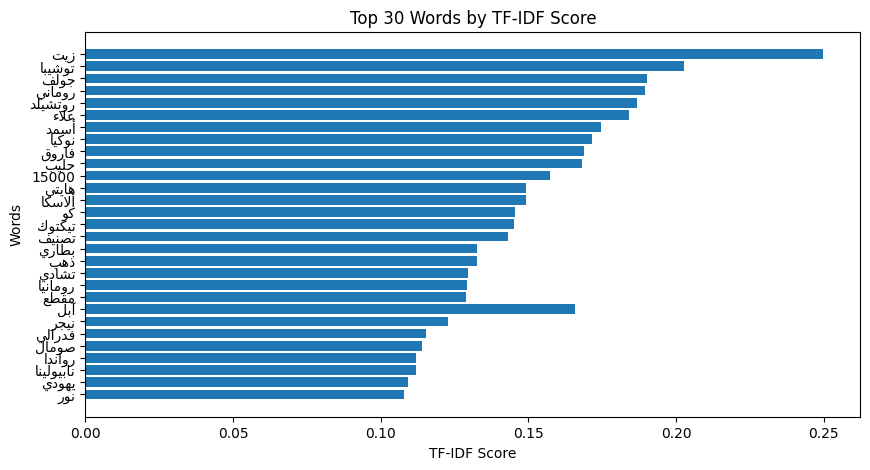

In [18]:
import arabic_reshaper
from bidi.algorithm import get_display
reshaped_words = [get_display(arabic_reshaper.reshape(word)) for word, _ in top_30_words]
scores = [score for _, score in top_30_words]

plt.figure(figsize=(10, 5))
plt.barh(reshaped_words[::-1], scores[::-1])
plt.xlabel("TF-IDF Score")
plt.ylabel("Words")
plt.title("Top 30 Words by TF-IDF Score")

plt.rcParams['font.family'] = 'Arial'
plt.show()


In [19]:
# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = sum(a * b for a, b in zip(vec1, vec2))
    mag_vec1 = math.sqrt(sum(a * a for a in vec1))
    mag_vec2 = math.sqrt(sum(b * b for b in vec2))
    print(f"Vector 1: {vec1}")
    print(f"Vector 2: {vec2}")
    print(f"Dot product: {dot_product}")
    print(f"Magnitude 1: {mag_vec1}, Magnitude 2: {mag_vec2}")

    if mag_vec1 == 0 or mag_vec2 == 0:
        return 0.0
    return dot_product / (mag_vec1 * mag_vec2)


def vectorSpaceModel(query, doc_dict, tfidf_scr):
    query_vocab = query.split(" ")

    query_vector = []
    for word in query_vocab:
        word_score = sum(tfidf_scr[file].get(word, 0) for file in tfidf_scr)  # Aggregate scores
        query_vector.append(word_score)

    if not any(query_vector):
        return []

    print(f"Query vector: {query_vector}")  # Debugging

    similarity_scores = []

    for doc_id, doc in doc_dict.items():
        # Create document vector
        doc_vector = [tfidf_scr[doc_id].get(word, 0) for word in query_vocab]

        # if not any(doc_vector):  # Skip empty document vectors
        #     continue

        print(f"Document {doc_id} vector: {doc_vector}")

        # Calculate cosine similarity
        similarity = cosine_similarity(query_vector, doc_vector)
        similarity_scores.append((doc_id, similarity))

    # Sort documents by similarity score
    similarity_scores.sort(key=lambda x: x[1], reverse=True)

    return similarity_scores[:5]  # Return top 5 documents


In [20]:
# Example query
query = "كوريا"
# Get the top 5 documents based on cosine similarity
top_5_docs = vectorSpaceModel(query, dic, tfidf)

# Output the top 5 documents
print("Top 5 documents:")
for doc_id, score in top_5_docs:
    print(f"Document: {doc_id} with similarity score: {score:.4f}")



Query vector: [0.19348638238589283]
Document المخبر_الاقتصادي__لماذا_عجزت_أمريكا_عن_سداد_ديونها_ولماذا_غضب_أصحاب_الديون.txt vector: [0]
Vector 1: [0.19348638238589283]
Vector 2: [0]
Dot product: 0.0
Magnitude 1: 0.19348638238589283, Magnitude 2: 0.0
Document المخبر_الاقتصادي__لماذا_تحالفت_روسيا_مع_كوريا_الشمالية_كيف_يهدد_هذا_التحالف_الاقتصاد_العالمي.txt vector: [0.06832361446500425]
Vector 1: [0.19348638238589283]
Vector 2: [0.06832361446500425]
Dot product: 0.013219688994362131
Magnitude 1: 0.19348638238589283, Magnitude 2: 0.06832361446500425
Document المخبر_الاقتصادي__لماذا_فتحت_أمريكا_لإسرائيل_مخبأ_السلاح_الذي_بنته_لأجل_العرب.txt vector: [0.002906311713761071]
Vector 1: [0.19348638238589283]
Vector 2: [0.002906311713761071]
Dot product: 0.0005623317395813741
Magnitude 1: 0.19348638238589283, Magnitude 2: 0.002906311713761071
Document المخبر_الاقتصادي___لماذا_قد_ينهار_اقتصاد_أمريكا_لو_استغنت_عن_الصين_من_يملك_خيوط_اللعبة.txt vector: [0]
Vector 1: [0.19348638238589283]
Vector 2: [0]
D

# Perform LDA Topic Modeling

In [23]:
# Perform LDA topic modeling
def perform_lda(dic):
    processed_docs = [list(word_counts.keys()) for word_counts in dic.values()]

    # Create dictionary and corpus
    dictionary = corpora.Dictionary(processed_docs)
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    # Train LDA model with 3 topics
    lda_model = models.LdaModel(corpus, num_topics=6, id2word=dictionary, passes=10,random_state=46)

    # Print topics
    topics = lda_model.print_topics(num_words=10)
    print("\nLDA Topics:")
    for topic in topics:
        print(topic)

    return lda_model, dictionary, corpus

In [24]:
lda_model, dictionary, corpus = perform_lda(dic)



LDA Topics:
(0, '0.001*"نهاي" + 0.001*"أشرف" + 0.001*"ود" + 0.001*"إبراهيم" + 0.001*"كبير" + 0.001*"سؤال" + 0.001*"جد" + 0.001*"شكل" + 0.001*"زي" + 0.001*"علشان"')
(1, '0.001*"حد" + 0.001*"مش" + 0.001*"دولة" + 0.001*"جد" + 0.001*"سن" + 0.001*"زي" + 0.001*"كبير" + 0.001*"قدر" + 0.001*"سلام" + 0.001*"ساعي"')
(2, '0.000*"بيساعدوا" + 0.000*"قران" + 0.000*"تتجسس" + 0.000*"بلانتير" + 0.000*"استخلاص" + 0.000*"تفهم" + 0.000*"ديمشن" + 0.000*"1651" + 0.000*"بيقعدوا" + 0.000*"اتصنت"')
(3, '0.001*"حال" + 0.001*"سلام" + 0.001*"حد" + 0.001*"مش" + 0.001*"ود" + 0.001*"أشرف" + 0.001*"مهم" + 0.001*"إبراهيم" + 0.001*"شكل" + 0.001*"نهاي"')
(4, '0.001*"شكل" + 0.001*"مهم" + 0.001*"ود" + 0.001*"أشرف" + 0.001*"حال" + 0.001*"سلام" + 0.001*"سن" + 0.001*"اشترك" + 0.001*"إبراهيم" + 0.001*"رئيس"')
(5, '0.001*"الله" + 0.001*"سن" + 0.001*"حلق" + 0.001*"جديد" + 0.001*"سلام" + 0.001*"كبير" + 0.001*"مهم" + 0.001*"اقتصادي" + 0.001*"مش" + 0.001*"ود"')
